In [1]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
import pathlib
import zipfile
import torch
import torchvision
from torchvision.transforms import transforms
from torch.utils.data import Dataset, DataLoader, ConcatDataset
import torch.optim as optim
import torch.nn.functional as F
from tqdm import tqdm
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
import torch.nn as nn
import pandas as pd
import seaborn as sns

In [2]:
import os

In [3]:
! conda install -y gdown
!gdown --id 1fOCHmxc1MrXc-AHnvcqYvHu0y9LupOhV
!gdown --id 1vkTHZqjYynj0-eymcFkPND4GvJvyd8BE
!unzip -u ./test.zip -d ./test 
!unzip -u ./train.zip -d ./train 

Solving environment: done

## Package Plan ##

  environment location: /opt/conda

  added / updated specs:
    - gdown


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    conda-4.10.3               |   py37h89c1867_2         3.1 MB  conda-forge
    filelock-3.1.0             |     pyhd8ed1ab_1          11 KB  conda-forge
    gdown-3.14.0               |     pyhd8ed1ab_0          12 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         3.1 MB

The following NEW packages will be INSTALLED:

  filelock           conda-forge/noarch::filelock-3.1.0-pyhd8ed1ab_1
  gdown              conda-forge/noarch::gdown-3.14.0-pyhd8ed1ab_0

The following packages will be UPDATED:

  conda                               4.10.3-py37h89c1867_1 --> 4.10.3-py37h89c1867_2



gdown-3.14.0         | 12 KB     | ####################

In [4]:
train='./train'
test='./test'

classes = os.listdir(test) 
print(classes)

def totalSize(path):
    sum = 0;
    for path, subdirs, files in os.walk(path):  ## walk directory    
        sum += len(files)
    return sum

print("Train Number Of Images : ",totalSize(train))
print("Test Number Of Images : ",totalSize(test))

['meningioma_tumor', 'glioma_tumor', 'pituitary_tumor', 'no_tumor']
Train Number Of Images :  2870
Test Number Of Images :  394


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.


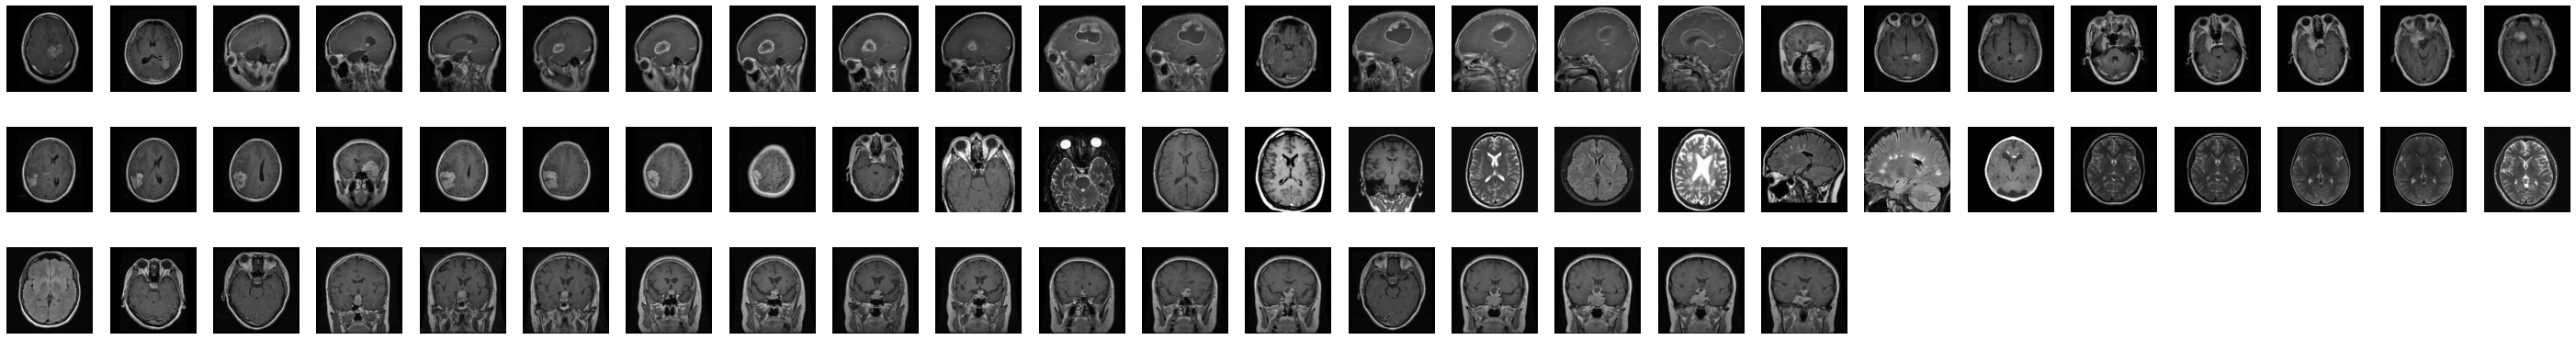

In [5]:
NUMBER_OF_IMAGE_SHOW = 17  ## how many image you want to show
preview_images_path = []

for path, subdirs, files in os.walk(train):
    subdirs.sort()
    files.sort()
    i = 0;
    for name in files:
        i +=1
        val = str( os.path.join(path, name) )
        preview_images_path.append(val)
        if(i is NUMBER_OF_IMAGE_SHOW):
            break

plt.figure(figsize=(50, 60))
for i,path in enumerate(preview_images_path):
    img = cv2.imread(path, cv2.COLOR_BGR2RGB)
    plt.subplot(50/2 , 25,i+1)
    # plt.imshow(img)
    plt.axis("off")
    plt.imshow(img[...,::-1]) # RGB-> BGR
plt.show()

In [6]:

BATCH_SIZE = 16  
IMAGE_SIZE = 224 
transform = transforms.Compose([

                                # torchvision.transforms.ColorJitter(brightness=0.4),
#                                 transforms.RandomRotation(20,expand=True), 
                                transforms.Resize(IMAGE_SIZE),  ## image resize
                                transforms.ToTensor(),
                                transforms.CenterCrop(IMAGE_SIZE),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                                
                               ])
train_loader=DataLoader(
    torchvision.datasets.ImageFolder(train,transform=transform),
    batch_size=BATCH_SIZE, shuffle=True
)

transform2 = transforms.Compose([
                                
                                transforms.Resize(IMAGE_SIZE),  ## image resize
                                transforms.ToTensor(), ## array converted into torch tensor and then divided by 255 (1.0/255)
                                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                               ])

test_loader=DataLoader(
    torchvision.datasets.ImageFolder(test,transform=transform2),
    batch_size=BATCH_SIZE, shuffle=True
)

In [46]:
import torchvision.models as models

models.vgg16(pretrained=True)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [47]:
# from torch.optim.lr_scheduler import StepLR
import torchvision.models as models
vgg16= models.vgg16(pretrained=True)

# image size must be >= 299 x 299 during training if aux_logits is set to be True.

vgg16.cuda()
num_classes =4
batch_size = BATCH_SIZE

learning_rate=0.0001

optimizer = torch.optim.Adam(vgg16.parameters(),lr=learning_rate)

# scheduler = StepLR(optimizer, step_size=5, gamma=0.1)
 
criterion = torch.nn.CrossEntropyLoss()

vgg16.fc = nn.Linear(4096, 4)
vgg16.cuda()
print("Model Is Ready To Run ")

Model Is Ready To Run 


In [48]:
vgg16

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [49]:
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [50]:
PATH='./vgg16.pth'

training_losses = []
training_accuracy = []
validation_losses = []
validation_accuracy = []
totalsteps = []
epochs = 10
steps = 0
running_loss = 0
print_every = 1

#epoch iteration
for epoch in range(epochs):
    accuracy = 0
    for inputs, labels in train_loader:
        vgg16.train()
        steps += 1
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad() # clears old gradients from the last step (otherwise you’d just accumulate the gradients from all loss.backward() calls).
        
        logps = vgg16.forward(inputs)
        loss = criterion(logps, labels)
        loss.backward() # computes the derivative of the loss w.r.t. the parameters (or anything requiring gradients) using backpropagation
        optimizer.step() # the optimizer to take a step based on the gradients of the parameters.
 
        #Calculate traning accuracy
        pred = torch.argmax(logps, dim=1)
        correct = pred.eq(labels)
       
        running_loss += loss.item()
        accuracy += torch.mean(correct.float())
        
        if steps % print_every == 0:
            after_train_accuracy=accuracy/print_every
            validation_loss = 0
            accuracy = 0
            vgg16.eval()
            with torch.no_grad():
                for inputs, labels in test_loader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    logps = vgg16.forward(inputs)
                    batch_loss = criterion(logps, labels)                    
                    validation_loss += batch_loss.item()
                    pred = torch.argmax(logps, dim=1)
                    correct = pred.eq(labels)
                    accuracy += torch.mean(correct.float())
            
            training_losses.append(running_loss/print_every)
            training_accuracy.append(after_train_accuracy)
            validation_losses.append(validation_loss/len(test_loader))
            validation_accuracy.append(accuracy/len(test_loader))
            totalsteps.append(steps)
            print(f"Device {device} "
                  f"Epoch {epoch+1}/{epochs} "
                  f"Step {steps} "
                  f"Train loss: {running_loss/print_every:f} "
                  f"Train accuracy: {after_train_accuracy:f} "
                  f"Validation loss: {validation_loss/len(test_loader):f} "
                  f"Validation accuracy: {accuracy/len(test_loader):f}")
            running_loss = 0
            accuracy = 0
            vgg16.train()
print('Finish Train')
torch.save(vgg16.state_dict(), PATH)

Device cuda Epoch 1/10 Step 1 Train loss: 13.526671 Train accuracy: 0.000000 Validation loss: 6.113185 Validation accuracy: 0.007500
Device cuda Epoch 1/10 Step 2 Train loss: 5.163123 Train accuracy: 0.062500 Validation loss: 4.054984 Validation accuracy: 0.144000
Device cuda Epoch 1/10 Step 3 Train loss: 4.841672 Train accuracy: 0.125000 Validation loss: 2.978851 Validation accuracy: 0.233000
Device cuda Epoch 1/10 Step 4 Train loss: 3.356727 Train accuracy: 0.375000 Validation loss: 2.229153 Validation accuracy: 0.278000
Device cuda Epoch 1/10 Step 5 Train loss: 2.436646 Train accuracy: 0.250000 Validation loss: 1.985918 Validation accuracy: 0.307000
Device cuda Epoch 1/10 Step 6 Train loss: 1.495355 Train accuracy: 0.437500 Validation loss: 2.204557 Validation accuracy: 0.292000
Device cuda Epoch 1/10 Step 7 Train loss: 1.685297 Train accuracy: 0.437500 Validation loss: 2.121252 Validation accuracy: 0.239500
Device cuda Epoch 1/10 Step 8 Train loss: 2.046030 Train accuracy: 0.375000

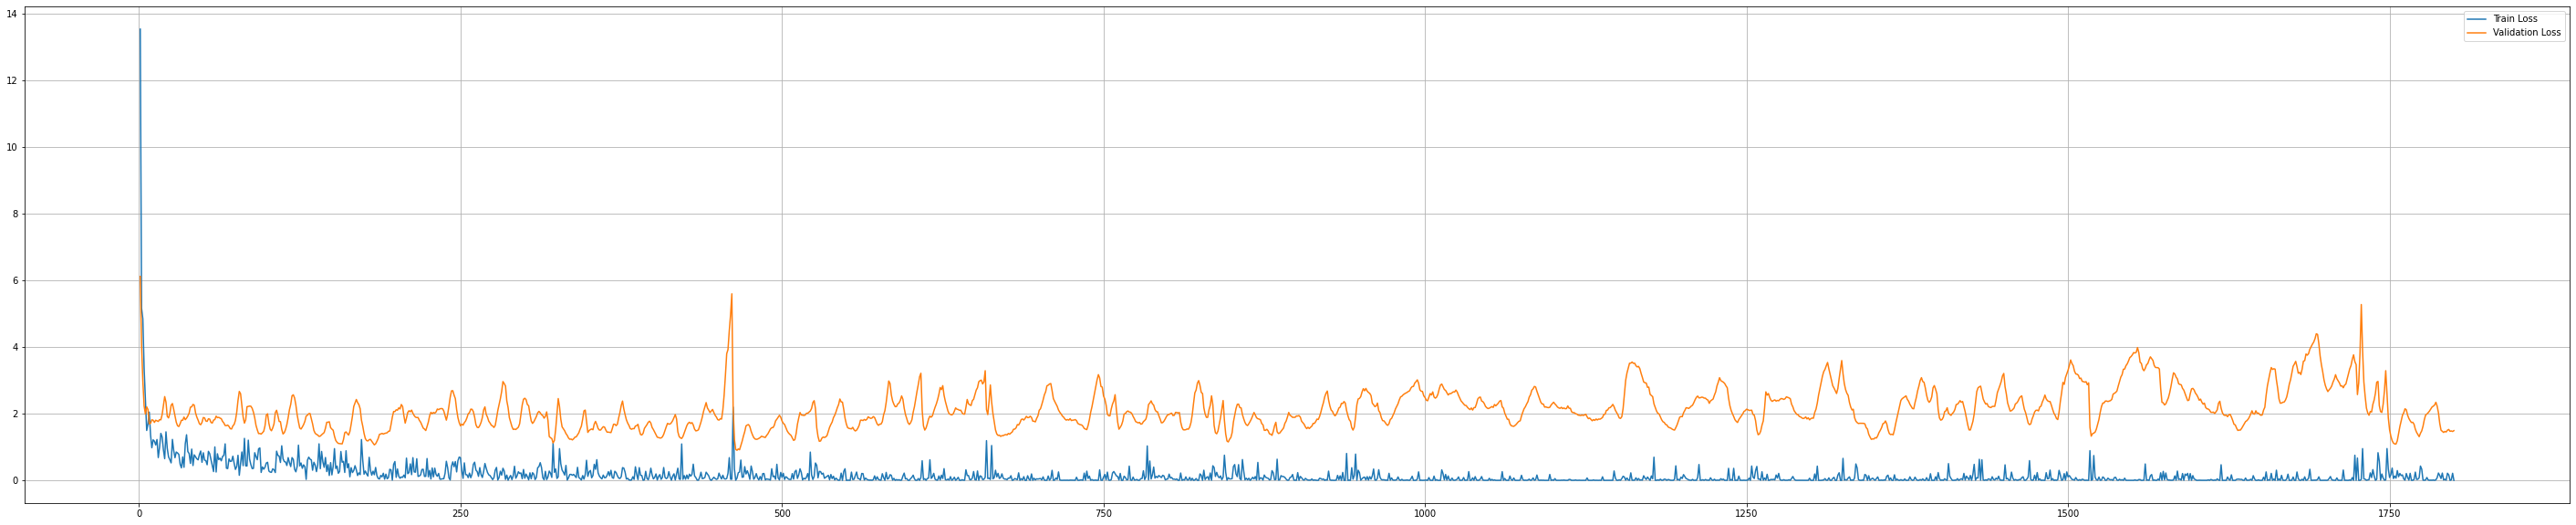

In [51]:
#display stats in graph
plt.figure(figsize=(50, 10))
plt.plot(totalsteps, training_losses, label='Train Loss')
plt.plot(totalsteps, validation_losses, label='Validation Loss')
plt.legend()
plt.grid()
plt.show()

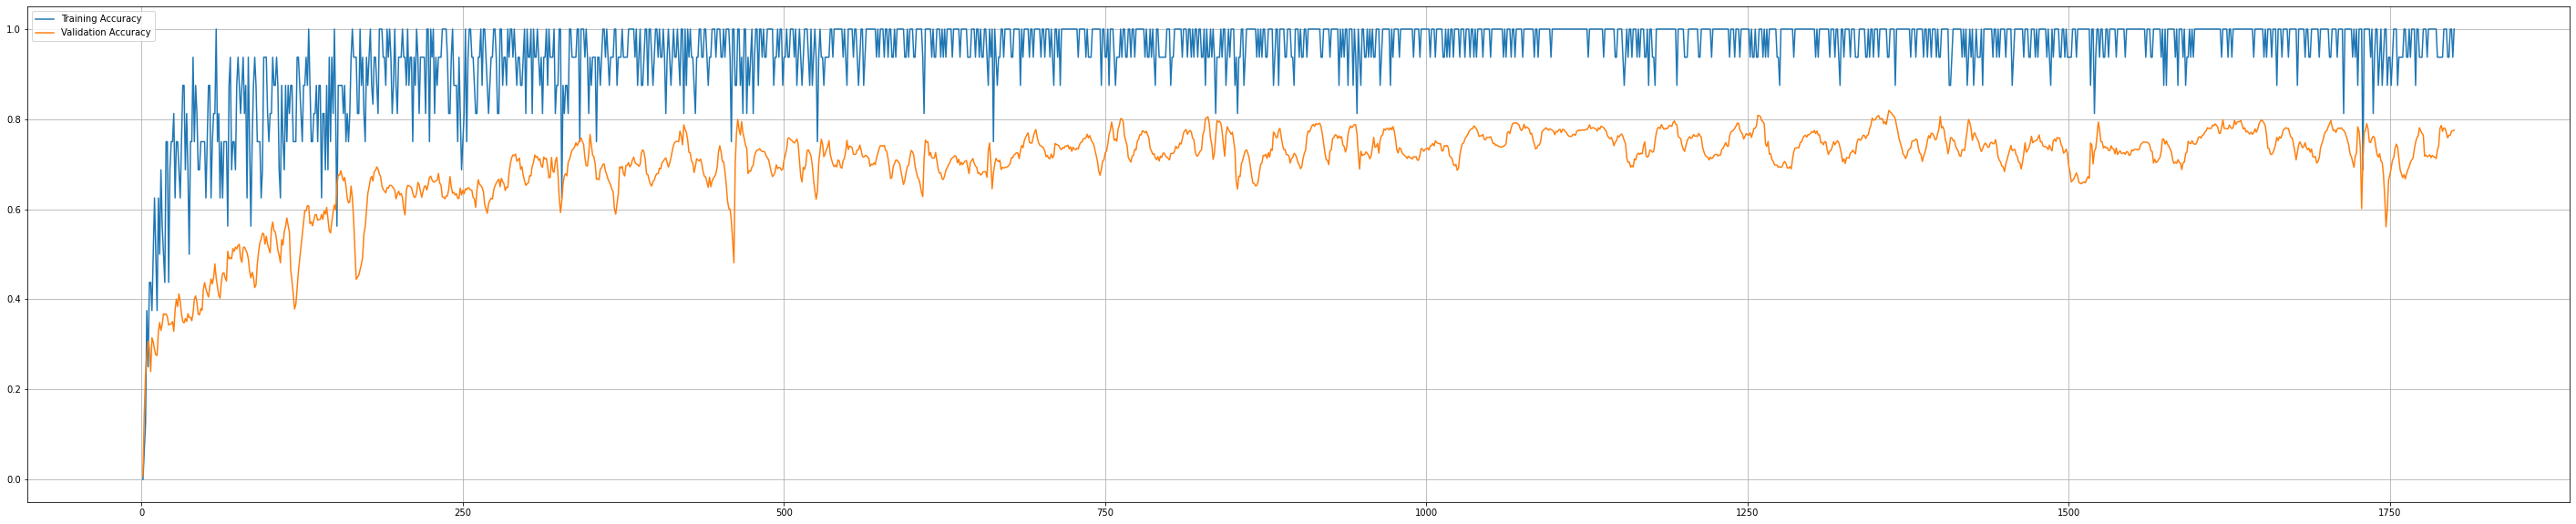

In [52]:
#display stats in graph
plt.figure(figsize=(50, 10))
plt.plot(totalsteps, training_accuracy, label='Training Accuracy')
plt.plot(totalsteps, validation_accuracy, label='Validation Accuracy')
plt.legend()
plt.grid()
plt.show()

In [53]:
total = 0
correct=0
with torch.no_grad():
    vgg16.eval()
    for inputs, labels in test_loader:
        
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = vgg16(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(total)
print(correct) 

print('Accuracy of the network test images: %d %%' % (100 * correct / total))

394
306
Accuracy of the network test images: 77 %


In [54]:
y_true_tensor = torch.tensor([]).cuda()
y_pred_tensor = torch.tensor([]).cuda()
vgg19.eval()
for i,(inputs, labels) in enumerate(test_loader):

  inputs, labels = inputs.to(device), labels.to(device)
  outputs = vgg19(inputs)
  _, preds = torch.max(outputs, 1)
  y_true_tensor = torch.cat((y_true_tensor,labels))
  y_pred_tensor = torch.cat((y_pred_tensor,preds))

In [55]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [56]:
y_true = y_true_tensor.tolist()
y_pred = y_pred_tensor.tolist()

In [57]:
matrix = confusion_matrix(y_true,y_pred)
matrix

array([[ 30,  40,  30,   0],
       [  0, 113,   1,   1],
       [  0,   0, 105,   0],
       [  0,   5,  13,  56]])

In [58]:
test_set = torchvision.datasets.ImageFolder(test, transform=transform2)


In [59]:
target_names = list(test_set.class_to_idx.keys())

In [60]:
classify_report = classification_report(y_true, y_pred, target_names=target_names)
print(classify_report)

                  precision    recall  f1-score   support

    glioma_tumor       1.00      0.30      0.46       100
meningioma_tumor       0.72      0.98      0.83       115
        no_tumor       0.70      1.00      0.83       105
 pituitary_tumor       0.98      0.76      0.85        74

        accuracy                           0.77       394
       macro avg       0.85      0.76      0.74       394
    weighted avg       0.83      0.77      0.74       394



Text(0.5, 14.09375, 'Predicted label')

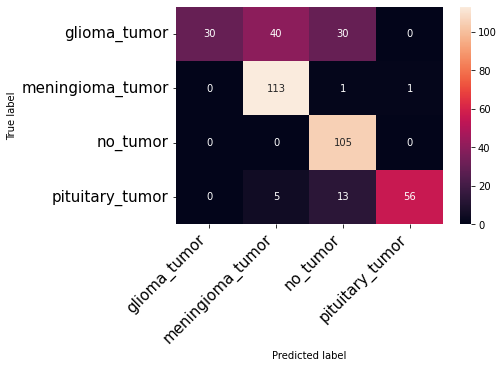

In [61]:
import pandas as pd
import seaborn as sns
df_cm = pd.DataFrame(matrix, index=target_names, columns=target_names).astype(int)
heatmap = sns.heatmap(df_cm, annot=True, fmt="d")

heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right',fontsize=15)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right',fontsize=15)
plt.ylabel('True label')
plt.xlabel('Predicted label')

In [62]:
# def test_class_probabilities(googlenet, device, test_loader, which_class):
#     googlenet.eval()
#     actuals = []
#     probabilities = []
#     with torch.no_grad():
#         for data, target in test_loader:
#             data, target = data.to(device), target.to(device)
#             output = googlenet(data)
#             prediction = output.argmax(dim=1, keepdim=True)
#             actuals.extend(target.view_as(prediction) == which_class)
#             probabilities.extend(np.exp(output[:, which_class]))
#     return [i.item() for i in actuals], [i.item() for i in probabilities]

# which_class = 4
# actuals, class_probabilities = test_class_probabilities(model, device, test_loader, which_class)

# fpr, tpr, _ = roc_curve(actuals, class_probabilities)
# roc_auc = auc(fpr, tpr)
# plt.figure()
# lw = 2
# plt.plot(fpr, tpr, color='darkorange',
#          lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
# plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('ROC for digit=%d class' % which_class)
# plt.legend(loc="lower right")
# plt.show()
